In [4]:
import networkx as nx

from agents import doubling_agent, local_ts_agent, local_ucb_agent
from graph_bandit_helper_tools import testQLearning,return_graph,draw_graph
from core import train_agent,visit_all_nodes
import graph_bandit

import numpy as np
from functools import partial

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

SEED = 181731

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import cvxpy as cp

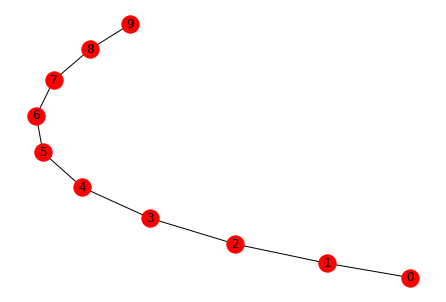

In [24]:
T = 1500

init_node = 1
np.random.seed(SEED)
n_nodes = 10
G = return_graph('line', n_nodes)
draw_graph(G)

means = np.random.uniform(low=0.5,high=9.5,size=n_nodes)

env = graph_bandit.GraphBandit(means,  G)

## Visit all nodes
visit_all_nodes(env)

H0 = len(env.visitedStates)

# Start learning

env.state = init_node

while len(env.visitedStates)-H0<T:
    # execute_agent(env)
    env.step(env.state)
    

regrets  = env.expectedRegret()[-T:]

# print(env.visitedStates.shape,regrets.shape)

# regrets[i,:]= env.expectedRegret()[:T]

# regrets[i,:]= env.expectedRegret()[-T:]

In [192]:
env.sasr
S = len(env.G)
A = len(env.G)
delta = 0.1

r_hat =  {(s,w):0 for s in env.G for w in env.G[s]}
P = {(s,w):np.zeros(len(env.G[s])) for s in env.G for w in env.G[s]}

N = {(s,w):0 for s in env.G for w in env.G[s]}

    
# Estimated mean reward and transition probabilities
for (s,w),hist in env.sasr.items():
        if len(hist)>0:
            hist = np.array(hist)
            nb = np.array([z for z in env.G[s]])
            counts = np.count_nonzero(hist[:,0]==nb.reshape(len(nb),1),axis=1)
            
            N[(s,w)] = len(hist)
            P[(s,w)] = counts/np.sum(counts)
        
            
            r_hat[(s,w)] = np.mean(hist[:,1])
            
###### Extended Value iteration #####
u = np.zeros(S)

tk = len(env.visitedStates)


# # The \tilde{r}(s,a) term.
r_ucb = {(s,w):r_hat[s,w]+np.sqrt(7*np.log(2*S*A*tk/delta) / 2*np.max([1,N[s,w]])) for s in env.G for w in env.G[s]}



# Iteration starts.

# while True:

for _ in range(10):
    
    old_u = np.zeros(u.shape)
    old_u[:] = u
    
    # The max_p \sum_{s'} p[s']u[s'] such that p is a probability distribution satisfying ||p-P[s,w]||_{1} <=  the confidence radius for P[s,w]
    U = {(s,w):0 for s in env.G for w in env.G[s]}

    for (s,w) in U.keys():
        if np.all(P[s,w]==0):
            U[s,w]=0
        else:
            not_nb = np.array([i for i in env.G if i not in env.G[s]])

            rad_P = np.sqrt(14*S*np.log(2*A*tk/delta) / np.max([1,N[s,w]]))

            p = cp.Variable(S,nonneg=True)

            constraints = [cp.sum(p)==1,
                           p<=1,p[not_nb]==0,
                           cp.norm(p[env.G[s]]-P[s,w],1)<=rad_P
                          ]

            prob = cp.Problem(cp.Maximize(p @ u),constraints)
            prob.solve()
            
            # print(p.value,u)

            U[s,w] = prob.value

    for s in env.G:
        # print(s,[r_ucb[s,w]+U[s,w] for w in env.G[s]])
        u[s] = np.max([r_ucb[s,w]+U[s,w] for w in env.G[s]])
        
    gap = np.max(u-old_u) - np.min(u-old_u)
    
    print(gap,u-old_u)
    # print(U)
    
    # print(u)
    



280.05315983387845 [ 14.64534579 287.27968638  15.69920731  15.56221995  12.39410772
   9.62420591  16.07782633  10.46573186   8.83259459   7.22652654]
287.27968640586363 [287.27968636 287.27968641 287.27968633  15.69920731  15.56221995
  16.07782633  16.07782632  16.07782632  10.46573185   0.        ]
287.2796864504257 [287.27968641 287.27968643 287.27968645 287.27968628  15.69920731
  16.07782632  16.07782632  16.07782632  16.07782633   0.        ]
287.2796864909174 [287.27968643 287.27968646 287.27968592 287.27968649 287.27968624
  16.07782633  16.07782632  16.07782632  16.07782632   0.        ]
287.2796865309292 [287.27968646 287.27968647 287.27968645 287.27968543 287.27968653
 282.7017422   16.07782632  16.07782632  16.07782632   0.        ]
287.27968657201563 [287.27968647 287.27968649 287.27968647 287.27968645 287.27968494
 287.27968657 276.24812175  16.07782632  16.07782632   0.        ]
287.2796866107075 [287.27968649 287.2796865  287.27968648 287.27968647 287.27968644
 287.27

# We can see that the extended value iteration may not terminate if the probability vector is close to a one-hot vector. So the UCRL2 algorithm cannot directly apply to our case without further modification.